# Aufbereitung der Messdaten               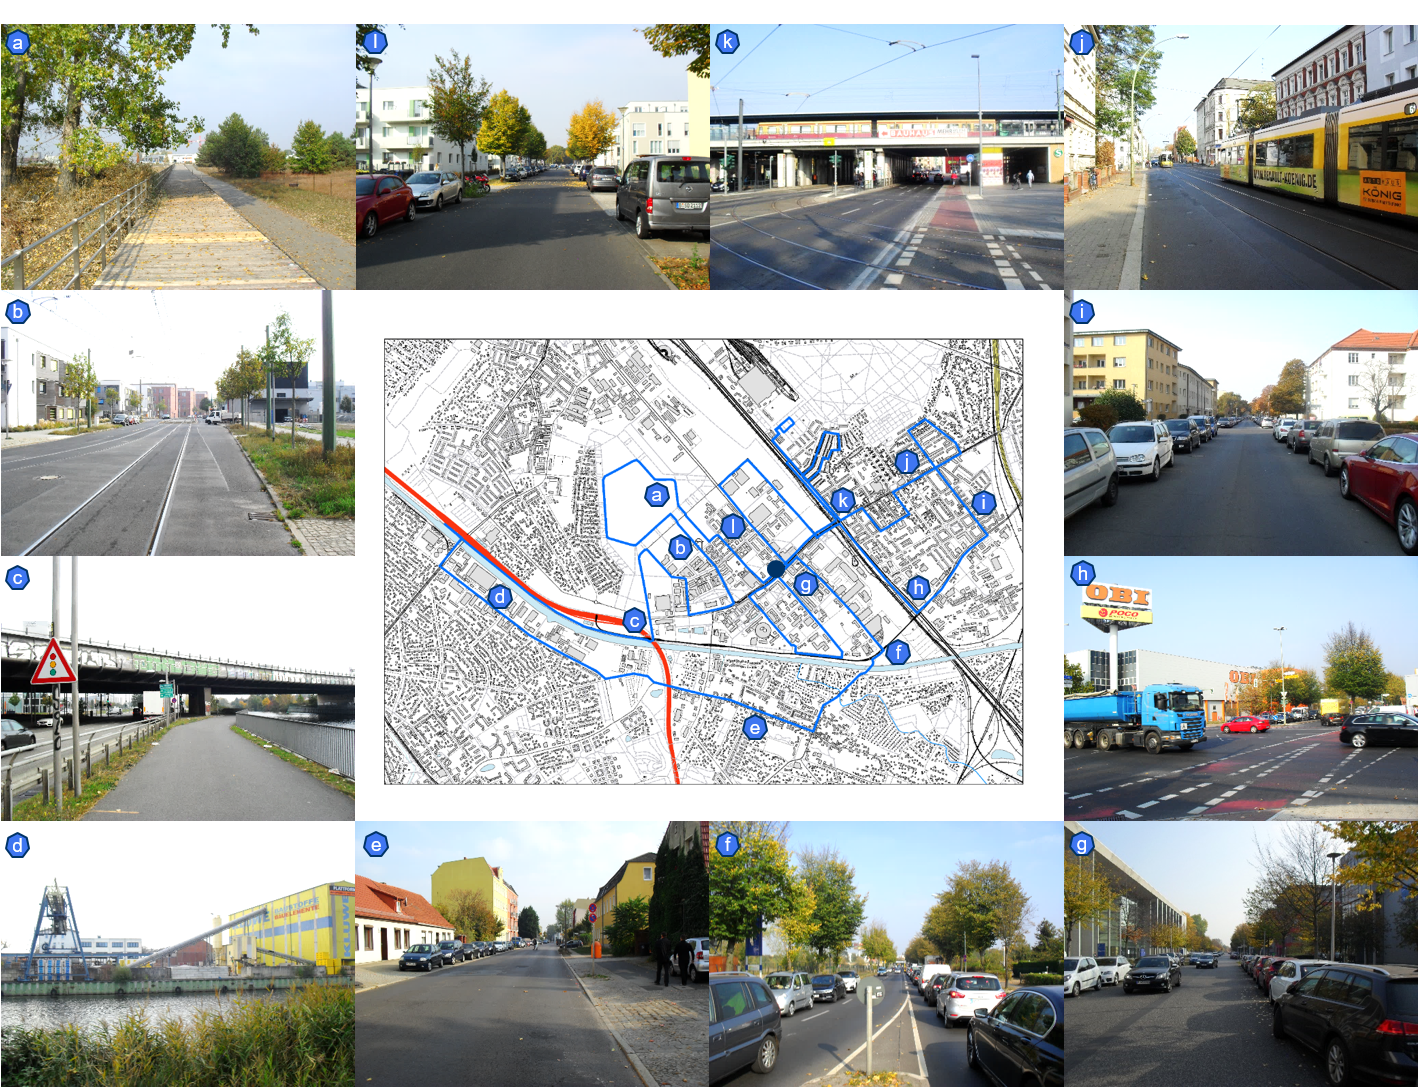

In diesem Notebook werfen wir einen ersten Blick auf unsere Ultrafeinstaubdaten und bereiten sie so auf, dass wir sie mit unseren GPS-Daten verknüpfen können. Die Messdaten befinden sich noch im Rohformat, wie sie das Messgerät ausgegeben hat. Folgende Probleme sind zu beachten:

- Wenn das Gerät Probleme beim Messen hat, gibt es den Wert **16777200** aus, diese Werte **müssen gelöscht werden.**
- Bei zu starker Erschütterung, fällt der Messwert auf 0 Partikel und braucht eine Weile um wieder hochzufahren. **Diese und die ca. 6 folgenden Messwerte müssen gelöscht werden.**
- Der **Zeitstempel** muss in ein Format gebracht werden, dass mit dem der Messroute (.gpx) übereinstimmt: `YYYY-MM-DD hh:mm:ss`

Bitte seht euch zunächst einmal die Datei im Ursprungsformat. Beide Problemfälle seht ihr z.B. ab Zeile 1550.

Im ersten Schritt laden wir wie immer die benötigten Pakete:

In [15]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sbn
import matplotlib.pyplot as plt

Dann definieren wir die Datenquelle über einen Pfad. Befindet sich die Datei im selben Ordner wie das Notebook, genügt der Dateiname. Solltet ihr den Code lokal auf eurem Computer ausführen, definiert ihr diesen als Text-String im Stile `"/home/user/eure/ordner/struktur/datei.csv"`.

In [16]:
path = "20180719_tour1_raw.csv"

Wir importieren die CSV-Datei als Pandas-Dataframe. Dafür definieren wir den Spaltentrenner (`","`), legen die erste Zeile als den Tabellenkopf (`header`) fest und übergeben direkt den Standard-Fehlerwert des Messgerätes.
Außerdem importieren wir die Spalte `'Time'` direkt im `Datetime`-Format.

In [17]:
data = pd.read_csv(path, sep = ",", header = 0,  na_values=(16777200), parse_dates=['Time'])

Wir schauen uns wieder exemplarisch die Zeilen ab 1550 an. Einerseits sehen wir, dass die Fehlerwerte auf `NaN` gesetzt wurden.

In [18]:
print(data[1545:1568])

                    Time  Concentration
1545 2021-11-30 10:58:21         3458.0
1546 2021-11-30 10:58:22         3448.0
1547 2021-11-30 10:58:23         3377.0
1548 2021-11-30 10:58:24            NaN
1549 2021-11-30 10:58:25            NaN
1550 2021-11-30 10:58:26            NaN
1551 2021-11-30 10:58:27            NaN
1552 2021-11-30 10:58:28            NaN
1553 2021-11-30 10:58:29            NaN
1554 2021-11-30 10:58:30            NaN
1555 2021-11-30 10:58:31            0.0
1556 2021-11-30 10:58:32            0.0
1557 2021-11-30 10:58:33            0.0
1558 2021-11-30 10:58:34            4.0
1559 2021-11-30 10:58:35          168.0
1560 2021-11-30 10:58:36          655.0
1561 2021-11-30 10:58:37         1185.0
1562 2021-11-30 10:58:38         1473.0
1563 2021-11-30 10:58:39         1710.0
1564 2021-11-30 10:58:40         1978.0
1565 2021-11-30 10:58:41         2336.0
1566 2021-11-30 10:58:42         2440.0
1567 2021-11-30 10:58:43         2597.0


Es fällt aber auch auf, dass die Zeitspalte das heutige Datum trägt. Die importierte Spalte enthielt lediglich eine Uhrzeit und wurde automatisch "vervollständigt".
Da wir wissen, dass die Messung am 19.07.2018 stattgefunden hat, ermitteln die Differenz zum heutigen Tag.

In [19]:
diff = data['Time'] - datetime.datetime(2018, 7, 19)
print(diff.head())

0   1230 days 10:32:36
1   1230 days 10:32:37
2   1230 days 10:32:38
3   1230 days 10:32:39
4   1230 days 10:32:40
Name: Time, dtype: timedelta64[ns]


"Herauslösen" der Ganzzahl aus dem Timedelta:

In [20]:
diff = int(str(diff[0])[0:4])
print(diff)

1230


Diesen Wert ziehen wir von der Datumsspalte ab. Beim Vergleich mit dem .gpx wird zudem deutlich, dass das die GPS-Anwendung in UTC aufgezeichnet hat. Das Messgerät jedoch in mitteleuropäischer Sommerzeit. Wir ziehen also weitere 2h ab.

In [21]:
data['Time'] = data['Time'] - pd.Timedelta(days = diff, hours=2)
data.head()

Time  Concentration
0 2018-07-19 08:32:36         3473.0
1 2018-07-19 08:32:37         3539.0
2 2018-07-19 08:32:38         3521.0
3 2018-07-19 08:32:39         3480.0
4 2018-07-19 08:32:40         3373.0

Nun kümmern wir uns um die Geräteausfälle. Um nicht versehentlich valide Zeilen zu löschen, erstellen wir eine Kopie des Datensatzes und arbeiten damit weiter.

In [22]:
data_c = data.copy()

Mit dem Befehl `iloc[]` können wir gezielt Zellen über ihre Position `[Zeile, Spalte]` anwählen.

In [23]:
print(data.iloc[1547,0])
print(data.iloc[1547,1])

2018-07-19 08:58:23
3377.0


Nun erstellen wir eine Schleife, die einzeln durch alle Reihen (`index`) läuft und in der zweiten Spalte nach dem Wert 0 sucht (Ausfall des Gerätes). Wo das der Fall ist, setzt die Schleife die betreffende Zeile und die nachfolgenden 6 Zeilen auf `NaN`.

In [24]:
for i in data.index:
       if data.iloc[i,1] == 0:
              data.iloc[i:i+7,1] = np.nan

print(data[1545:1568])

                    Time  Concentration
1545 2018-07-19 08:58:21         3458.0
1546 2018-07-19 08:58:22         3448.0
1547 2018-07-19 08:58:23         3377.0
1548 2018-07-19 08:58:24            NaN
1549 2018-07-19 08:58:25            NaN
1550 2018-07-19 08:58:26            NaN
1551 2018-07-19 08:58:27            NaN
1552 2018-07-19 08:58:28            NaN
1553 2018-07-19 08:58:29            NaN
1554 2018-07-19 08:58:30            NaN
1555 2018-07-19 08:58:31            NaN
1556 2018-07-19 08:58:32            NaN
1557 2018-07-19 08:58:33            NaN
1558 2018-07-19 08:58:34            NaN
1559 2018-07-19 08:58:35            NaN
1560 2018-07-19 08:58:36            NaN
1561 2018-07-19 08:58:37            NaN
1562 2018-07-19 08:58:38         1473.0
1563 2018-07-19 08:58:39         1710.0
1564 2018-07-19 08:58:40         1978.0
1565 2018-07-19 08:58:41         2336.0
1566 2018-07-19 08:58:42         2440.0
1567 2018-07-19 08:58:43         2597.0


Wie man sehen kann, sind nach der letzten der drei aufeinanderfolgenden 0-Zeilen nur 4 Zeilen `NaN` gesetzt worden, da die letzten beiden von der Schleife schon in der ersten 0-Zeile überschrieben wurden. Um das zu verhindern, lassen wir die Schleife einfach von hinten nach vorne (`reversed`) durch den Datensatz iterieren, da sich die 6 Zeilen "Sicherheitsabstand" ja auf die Zeit nach dem Ausfall beziehen.

In [25]:
for i in reversed(data.index):
       if data.iloc[i,1] == 0:
              data.iloc[i:i+7,1] = np.nan

print(data[1545:1568])

                    Time  Concentration
1545 2018-07-19 08:58:21         3458.0
1546 2018-07-19 08:58:22         3448.0
1547 2018-07-19 08:58:23         3377.0
1548 2018-07-19 08:58:24            NaN
1549 2018-07-19 08:58:25            NaN
1550 2018-07-19 08:58:26            NaN
1551 2018-07-19 08:58:27            NaN
1552 2018-07-19 08:58:28            NaN
1553 2018-07-19 08:58:29            NaN
1554 2018-07-19 08:58:30            NaN
1555 2018-07-19 08:58:31            NaN
1556 2018-07-19 08:58:32            NaN
1557 2018-07-19 08:58:33            NaN
1558 2018-07-19 08:58:34            NaN
1559 2018-07-19 08:58:35            NaN
1560 2018-07-19 08:58:36            NaN
1561 2018-07-19 08:58:37            NaN
1562 2018-07-19 08:58:38         1473.0
1563 2018-07-19 08:58:39         1710.0
1564 2018-07-19 08:58:40         1978.0
1565 2018-07-19 08:58:41         2336.0
1566 2018-07-19 08:58:42         2440.0
1567 2018-07-19 08:58:43         2597.0


Anschließend löschen wir alle Zeilen, die `Nan`-Werte enthalten. Mit der Kombination der Funktionen `.isna()` und `.sum()` überprüfen wir die Zahl der `NaN`-Werte.

In [26]:
print(data.isna().sum())
data = data.dropna()
print(data[1545:1568])

Time              0
Concentration    98
dtype: int64
                    Time  Concentration
1545 2018-07-19 08:58:21         3458.0
1546 2018-07-19 08:58:22         3448.0
1547 2018-07-19 08:58:23         3377.0
1562 2018-07-19 08:58:38         1473.0
1563 2018-07-19 08:58:39         1710.0
1564 2018-07-19 08:58:40         1978.0
1565 2018-07-19 08:58:41         2336.0
1566 2018-07-19 08:58:42         2440.0
1567 2018-07-19 08:58:43         2597.0
1568 2018-07-19 08:58:44         2725.0
1569 2018-07-19 08:58:45         2888.0
1570 2018-07-19 08:58:46         2966.0
1571 2018-07-19 08:58:47         3289.0
1572 2018-07-19 08:58:48         3304.0
1573 2018-07-19 08:58:49         3551.0
1574 2018-07-19 08:58:50         3539.0
1575 2018-07-19 08:58:51         3640.0
1576 2018-07-19 08:58:52         3700.0
1577 2018-07-19 08:58:53         3609.0
1578 2018-07-19 08:58:54         3612.0
1579 2018-07-19 08:58:55         3719.0
1580 2018-07-19 08:58:56         3662.0
1581 2018-07-19 08:58:57   

Nun verschaffen wir uns einen schnellen Überblick über den Datensatz. Was fällt auf?

       Concentration
count    6739.000000
mean     7171.845823
std      6076.327817
min      1473.000000
25%      4515.000000
50%      5368.000000
75%      7494.000000
max    106336.000000


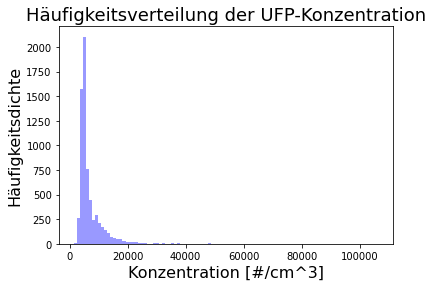

In [27]:
print(data.describe())

sbn.distplot(data['Concentration'], kde=False, color='blue', bins=100)
plt.title('Häufigkeitsverteilung der UFP-Konzentration', fontsize=18)
plt.xlabel('Konzentration [#/cm^3]', fontsize=16)
plt.ylabel('Häufigkeitsdichte', fontsize=16)
plt.show()

Zuletzt speichern wir den Dataframe wieder als CSV.

In [28]:
data.to_csv("20180719_tour1_edit.csv", index=False)

Solltet ihr in einer Browser-basierten Umgebung arbeiten, geht nun bitte zurück in die Dateiübersicht und ladet euch dort den eben erstellten Datensatz für die weitere Verwendung in QGIS herunter.